In [1]:
from src.lstm_ed import LSTM_ED

import torch
import src
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

__CUDNN VERSION: 7605
__Number CUDA Devices: 1
__CUDA Device Name: GeForce GTX 1060
__CUDA Device Total Memory [GB]: 6.373572608
Device:  cuda


In [3]:
# from sklearn.preprocessing import LabelEncoder
# from datasets import ucr_2018, utils

# train_df, test_df = ucr_2018.get_dataset("ECG200")
# X_train, y_train = utils.x_y_split(train_df, y_col=0)
# X_test, y_test = utils.x_y_split(test_df, y_col=0)

# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.transform(y_test)

In [4]:
# params = {
#     'batch_size': 10,
#     'shuffle': True
# }

# train = torch.utils.data.TensorDataset(
#     torch.from_numpy(X_train.values).unsqueeze(-1).float().to(device),
#     torch.tensor(y_train).to(device)
# )
# train_loader = torch.utils.data.DataLoader(train, **params)

# test = torch.utils.data.TensorDataset(
#     torch.from_numpy(X_test.values).unsqueeze(-1).float().to(device),
#     torch.tensor(y_test).to(device)
# )
# test_loader = torch.utils.data.DataLoader(test, **params)

In [5]:
# epochs = 10
# model = LSTM_ED(input_size=1, seq_len=96, device=device)
# model.train(train_loader=train_loader, validation_loader=None,
#             data_storage="records", epochs=epochs, model_name="LSTM-ED",
#             logdir="logs", verbose=1)

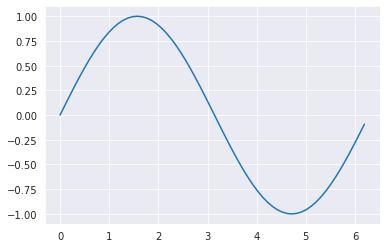

In [6]:
t = np.linspace(0, 32*np.pi, 1024)
x = np.sin(t)
plt.plot(t[:64], x[:64]);

In [7]:
from src.utils import data

window = 64
params = {
    'batch_size': 10,
    'shuffle': False#True
}
train_loader = data.create_data_loader(
    x=torch.tensor(x),
    window=window,
    model_type="LSTM",
    device=device,
    anomalies=torch.zeros(len(x)),
    **params
)

In [8]:
epochs = 10
model = LSTM_ED(input_size=1, seq_len=window, device=device)
model.train(train_loader=train_loader, validation_loader=None,
            data_storage="records", epochs=epochs, model_name="LSTM-ED",
            logdir="logs", verbose=1)

Epoch 0, dataset train: Loss - 0.500257, MSE - 0.500257
Epoch 1, dataset train: Loss - 0.497063, MSE - 0.497063
Epoch 2, dataset train: Loss - 0.489207, MSE - 0.489207
Epoch 3, dataset train: Loss - 0.439689, MSE - 0.439689
Epoch 4, dataset train: Loss - 0.418361, MSE - 0.418361
Epoch 5, dataset train: Loss - 0.408600, MSE - 0.408600
Epoch 6, dataset train: Loss - 0.396407, MSE - 0.396407
Epoch 7, dataset train: Loss - 0.373503, MSE - 0.373503
Epoch 8, dataset train: Loss - 0.273565, MSE - 0.273565
Epoch 9, dataset train: Loss - 0.097600, MSE - 0.097600


# Brudnopis

In [9]:
from scipy.sparse import csr_matrix

m = csr_matrix((len(t), len(t)))
for i, (x_batch, _, _) in enumerate(train_loader):
    x_pred = model(x_batch).cpu().detach().numpy()
    batch_size = x_pred.shape[0]
    for j in range(batch_size):
        m[[i*batch_size + j]*window, list(range(i*batch_size + j, i*batch_size + j + window))] =\
            x_pred[j, :, 0]
m

/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<1024x1024 sparse matrix of type '<class 'numpy.float64'>'
	with 61440 stored elements in Compressed Sparse Row format>

<ipython-input-10-fd0636fd51ba>:2: RuntimeWarning: invalid value encountered in double_scalars
  x_pred_mean = [m_arr[:,i].sum()/np.count_nonzero(m_arr[:,i]) for i in range(m_arr.shape[0])]


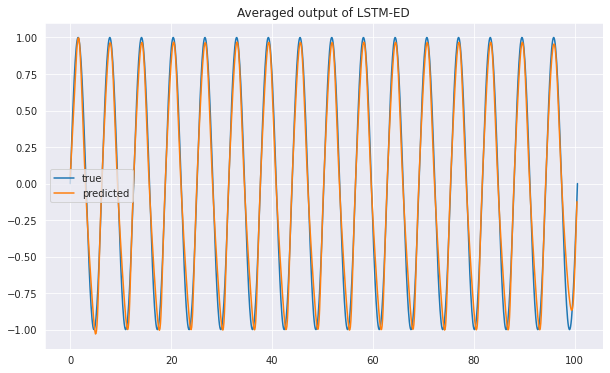

In [10]:
m_arr = m.toarray()
x_pred_mean = [m_arr[:,i].sum()/np.count_nonzero(m_arr[:,i]) for i in range(m_arr.shape[0])]
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(t, x, label="true")
ax.plot(t, x_pred_mean, label="predicted")
ax.legend()
ax.set_title("Averaged output of LSTM-ED")
plt.show();

In [11]:
#!rm -rf ./logs/LSTM-ED